In [ ]:
#**************************#
#import packages
#**************************#

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer

#from sklearn.preprocessing import MinMaxScaler
#from sklearn.impute import SimpleImputer 

from sklearn.feature_selection import SelectKBest , chi2, f_classif

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix , classification_report, roc_auc_score, f1_score, accuracy_score
from sklearn import tree

from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import pandas_profiling
import warnings
warnings.filterwarnings('ignore')

#**************************#
#import and Explore data
#**************************#
df = pd.read_excel("data/Bankruptcy_data_Final.xlsx")
df.head()

data = df.copy()

#Data Statistics
print(df.describe().transpose())

# Check missing value
print(df.isnull().sum())


#pandas_profiling.ProfileReport(df)

# target distribution -- Class0: 99.4%, Class1 : 0.6%
print(df["BK"].value_counts())

#****************************#
#Data Cleaning and Engineering 
#****************************#
#Drop rows with more than 3 missing values
df = df[df.isnull().sum(axis=1) < 3]

#Fill remaining missing value with 0
df = df.fillna(0)

#Feature Scaling
df.drop(['Data Year - Fiscal' ], axis = 1 , inplace = True)

num_features = [col for col in df.columns if col != 'BK']

scaler = PowerTransformer(method='yeo-johnson')
df[num_features] = scaler.fit_transform(df[num_features])

#Histogram
df.hist(figsize = (13,13), bins = 20)
plt.show()

#Export the cleaned data
df.to_csv('data/cleaned_data.csv')

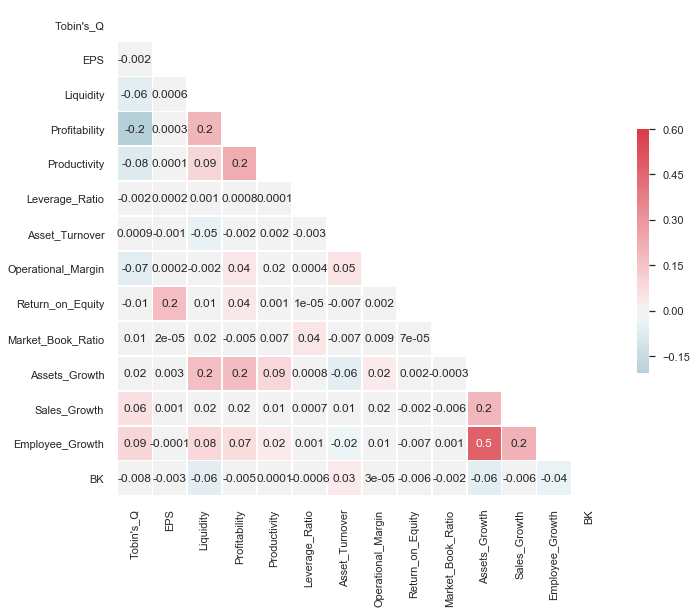

In [7]:
sns.set(style="white")

corr_matrix = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt=".0")
plt.show()

In [60]:
#Split data to train and test sets
train , test = train_test_split(df, random_state = 42 , test_size = 0.2 , stratify = df['BK'])

In [61]:
train["BK"].value_counts() , test["BK"].value_counts()

(0    68334
 1      443
 Name: BK, dtype: int64, 0    17084
 1      111
 Name: BK, dtype: int64)

In [62]:
target = "BK"
features = list(train.columns)

features = [f for f in features if f!=target]

X_train = train[features].reset_index(drop=True)
y_train = train[[target]].reset_index(drop=True)


X_test = test[features].reset_index(drop=True)
y_test = test[[target]].reset_index(drop=True)

In [63]:
def GridSearch_func(X,y, estimator, param_grid, cv=10 , scoring = 'roc_auc'):

    grid_search = GridSearchCV(estimator, param_grid, cv=cv,
                           scoring=scoring)
    grid_search.fit(X, y)
    print ("best parameters: ", grid_search.best_params_)
    #print(f"best {scoring} score during training: ", grid_search.best_score_)
    print("-------"*10)
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    print(f"mean of {scoring} scores during validation: {sum(means)/len(means):0.3f}")
    print("-------"*10)
    best_model = grid_search.best_estimator_
    print ("best_model: ", best_model)
    
    return best_model

In [64]:
def metrics( clf, X_test , y_test = y_test):
    
    y_pred = clf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print()
    print(cm)
    print("-----"*5)
    
    print(classification_report(y_test, y_pred))
    print("-----"*5)
    
    y_proba = clf.predict_proba(X_test)
    y_scores = y_proba[:, 1]
    auc = roc_auc_score (y_test, y_scores)
    
    print()
    print(f"ROC AUC score: {auc:.3f}")

    f1 = f1_score(y_test, y_pred)
    print(f"f1 score: {f1:.3f}")
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.3f}")
    
    kappa = cohen_kappa_score(y_test, y_pred)
    print(f"Kappa: {kappa:.3f}".format())
    
    logLoss = log_loss(y_test, y_scores)
    print(f"Log loss: {logLoss:.3f}".format())
    
    metrics = pd.DataFrame({"Accuracy" :[acc], "AUC" : [auc], "f1": [f1], "Kappa": [kappa], "Log Loss": [logLoss]}).round(3)
    return metrics

In [67]:
#Logistic Regression
lg_clf = LogisticRegression(n_jobs = -1 , class_weight= {0:0.01, 1:0.99} )
param_grid_lg = [{"penalty" :['l1', 'l2'] , "C" :[ 0.1, 1 ]}]
lg_model = GridSearch_func(X = X_train, y= np.ravel(y_train),
                           estimator = lg_clf, param_grid = param_grid_lg, cv= 5  , scoring = "roc_auc" )

C:\Users\Nafiseh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Nafiseh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Nafiseh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Nafiseh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Nafiseh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Defaul

C:\Users\Nafiseh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Nafiseh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
C:\Users\Nafiseh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Nafiseh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


best parameters:  {'C': 1, 'penalty': 'l1'}
----------------------------------------------------------------------
0.768 (+/-0.045) for {'C': 0.1, 'penalty': 'l1'}
0.771 (+/-0.037) for {'C': 0.1, 'penalty': 'l2'}
0.771 (+/-0.037) for {'C': 1, 'penalty': 'l1'}
0.771 (+/-0.037) for {'C': 1, 'penalty': 'l2'}

mean of roc_auc scores during validation: 0.770
----------------------------------------------------------------------
best_model:  LogisticRegression(C=1, class_weight={0: 0.01, 1: 0.99}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=-1, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


In [68]:
print("Logistic Regression Classifier" )
print()
log_reg_metrics = metrics(lg_model, X_test)

Logistic Regression Classifier

Confusion Matrix:

[[15607  1477]
 [   55    56]]
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     17084
           1       0.04      0.50      0.07       111

    accuracy                           0.91     17195
   macro avg       0.52      0.71      0.51     17195
weighted avg       0.99      0.91      0.95     17195

-------------------------
ROC AUC score: 0.7697

f1 score: 0.0681
